# Network Visualisation of Singapore's Public Bus Transport System

First, to obtain the data set, we need to make API calls using the one provided for LTA's DataMall. 

In [1]:
import requests

In [ ]:
api_key = 'your_API_key'
base_url = 'the_URL_to_make_API_calls_on'

In [ ]:
headers = {
    'AccountKey' : api_key,
    'accept' : 'application/json'
}

In [ ]:
page = 1
all_values = []

while True:
    params = {
        '$skip': (page - 1)*500
    }
    response = requests.get(base_url, 
                            params = params,
                            headers = headers)
    print(f"extracting page {page}")
    values = response.json()['value']
    all_values.extend(values)
    if len(values) != 500:
        break
    page += 1

In [40]:
import pandas as pd 

In [2]:
file_name = pd.DataFrame(all_values)

In [ ]:
# To convert to a csv file if required
file_name.to_csv("file_name.csv", index = False)

Next, to sort the obtained data set: 
First, import the origin destination trip records,

In [3]:
od_three_months = pd.read_csv('od_three_months.csv',\
                usecols=['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE', 'TOTAL_TRIPS'])

od_three_months['ORIGIN_PT_CODE'] = od_three_months['ORIGIN_PT_CODE'].astype("str").str.zfill(5)
od_three_months['DESTINATION_PT_CODE'] = od_three_months['DESTINATION_PT_CODE'].astype("str").str.zfill(5)

Since we have three months worth of data, it is easier to analyse it when the data is combined as a whole. 
The `.groupby` method takes in an attribute, and groups the data according to the categories, hence applying a function to the category. 

In [4]:
od_modified = od_three_months.groupby(['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])['TOTAL_TRIPS'].sum()

In [5]:
od_stops = od_modified.reset_index()

In [6]:
od_stops.head()

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS
0          01012               01112         4821
1          01012               01113         3660
2          01012               01121         2306
3          01012               01211         3432
4          01012               01311         5780

Next, import the bus stop data. 

In [7]:
bus_stops = pd.read_csv('bus_stops.csv')
bus_stops["BusStopCode"] = bus_stops["BusStopCode"].astype("str").str.zfill(5)
bus_stops.head(5)

BusStopCode       RoadName          Description  Latitude   Longitude
0       01012    Victoria St  Hotel Grand Pacific  1.296848  103.852536
1       01013    Victoria St      St. Joseph's Ch  1.297710  103.853225
2       01019    Victoria St      Bras Basah Cplx  1.296990  103.853022
3       01029  Nth Bridge Rd         Opp Natl Lib  1.296673  103.854414
4       01039  Nth Bridge Rd           Bugis Cube  1.298208  103.855491

For a more comprehensive overview of where the bus stops are located, we will require the subzone name and region of each bus stop. 

In [8]:
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [9]:
geo_df = gpd.read_file('MP19_SZ_No_Sea/URA_MP19_SUBZONE_NO_SEA_PL.shp')

In [10]:
geo_df_reproj = geo_df.to_crs(3857)

In [11]:
geo_df_reproj.columns

Index(['SUBZONE_NO', 'SUBZONE_N', 'SUBZONE_C', 'CA_IND', 'PLN_AREA_N',
       'PLN_AREA_C', 'REGION_N', 'REGION_C', 'INC_CRC', 'FMEL_UPD_D',
       'geometry'],
      dtype='object')

In [12]:
from shapely.geometry import Point
# Creating a point geometry column
bus_stops['geometry'] = bus_stops.apply(lambda x: Point((x.Longitude, x.Latitude)),
                                       axis = 1)

In [13]:
# Create a GeoDataFrame from the original bus_stops DataFrame
bus_stops_geo = gpd.GeoDataFrame(bus_stops, 
                                 crs = "epsg:4326",
                                 geometry = bus_stops.geometry)
bus_stops_geo_reproj = bus_stops_geo.to_crs(3857)

In [14]:
joined_gdf = gpd.sjoin(bus_stops_geo_reproj, 
                       geo_df_reproj, 
                       how = 'left')

As I will only require the BusStopCode, Subzone Name and Region Name, the geo_df obtained needs to be subset by columns. 
I will also need to convert the subsequent GeoDataFrame into a DataFrame. 

In [15]:
joined_gdf.columns

Index(['BusStopCode', 'RoadName', 'Description', 'Latitude', 'Longitude',
       'geometry', 'index_right', 'SUBZONE_NO', 'SUBZONE_N', 'SUBZONE_C',
       'CA_IND', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N', 'REGION_C', 'INC_CRC',
       'FMEL_UPD_D'],
      dtype='object')

In [16]:
# Subset the current joined geo_df to get the columns I need.
required_bus_stops = joined_gdf[['BusStopCode', 'SUBZONE_N', 'PLN_AREA_N', 'REGION_N']]
required_bus_stops.head()

BusStopCode SUBZONE_N     PLN_AREA_N        REGION_N
0       01012  VICTORIA         ROCHOR  CENTRAL REGION
1       01013  VICTORIA         ROCHOR  CENTRAL REGION
2       01019     BUGIS  DOWNTOWN CORE  CENTRAL REGION
3       01029     BUGIS  DOWNTOWN CORE  CENTRAL REGION
4       01039     BUGIS  DOWNTOWN CORE  CENTRAL REGION

In [17]:
bus_stops_df = pd.DataFrame(required_bus_stops)

In [18]:
# To join the 2 datasets we have obtained:
od_stops = pd.merge(od_stops, bus_stops_df,\
                    how = 'left', left_on ='ORIGIN_PT_CODE', right_on = 'BusStopCode')
od_stops = pd.merge(od_stops, bus_stops_df,\
             how = 'left', left_on = 'DESTINATION_PT_CODE', right_on = 'BusStopCode')
od_stops.head(10)

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS BusStopCode_x SUBZONE_N_x  \
0          01012               01112         4821         01012    VICTORIA   
1          01012               01113         3660         01012    VICTORIA   
2          01012               01121         2306         01012    VICTORIA   
3          01012               01211         3432         01012    VICTORIA   
4          01012               01311         5780         01012    VICTORIA   
5          01012               01549           22         01012    VICTORIA   
6          01012               01559           78         01012    VICTORIA   
7          01012               07371          227         01012    VICTORIA   
8          01012               60011          321         01012    VICTORIA   
9          01012               60021          343         01012    VICTORIA   

  PLN_AREA_N_x      REGION_N_x BusStopCode_y    SUBZONE_N_y   PLN_AREA_N_y  \
0       ROCHOR  CENTRAL REGION         01112       VICTORIA         ROCHOR   
1       ROCHOR  CENTRAL REGION         01113          BUGIS  DOWNTOWN CORE   
2       ROCHOR  CENTRAL REGION         01121   ROCHOR CANAL         ROCHOR   
3       ROCHOR  CENTRAL REGION         01211       CRAWFORD        KALLANG   
4       ROCHOR  CENTRAL REGION         01311       LAVENDER        KALLANG   
5       ROCHOR  CENTRAL REGION         01549   KAMPONG GLAM         ROCHOR   
6       ROCHOR  CENTRAL REGION         01559   KAMPONG GLAM         ROCHOR   
7       ROCHOR  CENTRAL REGION         07371       LAVENDER        KALLANG   
8       ROCHOR  CENTRAL REGION         60011  KALLANG BAHRU        KALLANG   
9       ROCHOR  CENTRAL REGION         60021  KALLANG BAHRU        KALLANG   

       REGION_N_y  
0  CENTRAL REGION  
1  CENTRAL REGION  
2  CENTRAL REGION  
3  CENTRAL REGION  
4  CENTRAL REGION  
5  CENTRAL REGION  
6  CENTRAL REGION  
7  CENTRAL REGION  
8  CENTRAL REGION  
9  CENTRAL REGION

In [19]:
# rename the df for easier use
final_df = od_stops

In [23]:
final_df.shape

(372020, 11)

To figure out where is the cut_off point for number of trips made:

In [39]:
import seaborn as sns

A couple of test cases to visualise how to obtain the general graph object function. 

In [32]:
# TESTCASE 1 
trips = final_df[['SUBZONE_N_x', 'SUBZONE_N_y']]\
    .loc[((final_df['REGION_N_x']=='CENTRAL REGION') & (final_df['REGION_N_y']=='CENTRAL REGION'))]\
    .value_counts()

trips.head()

SUBZONE_N_x      SUBZONE_N_y    
ALJUNIED         ALJUNIED           333
ANAK BUKIT       ANAK BUKIT         323
PASIR PANJANG 1  PASIR PANJANG 1    318
BALESTIER        BALESTIER          302
UPPER THOMSON    UPPER THOMSON      274
dtype: int64

In [33]:
links = pd.DataFrame.from_records(list(trips.index),\
                                 columns = ['start', 'end'])
links['trips'] = trips.values

links.head()

start              end  trips
0         ALJUNIED         ALJUNIED    333
1       ANAK BUKIT       ANAK BUKIT    323
2  PASIR PANJANG 1  PASIR PANJANG 1    318
3        BALESTIER        BALESTIER    302
4    UPPER THOMSON    UPPER THOMSON    274

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
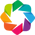

In [35]:
from holoviews import opts, dim
import holoviews as hv

hv.extension('bokeh')
hv.output(size=200)

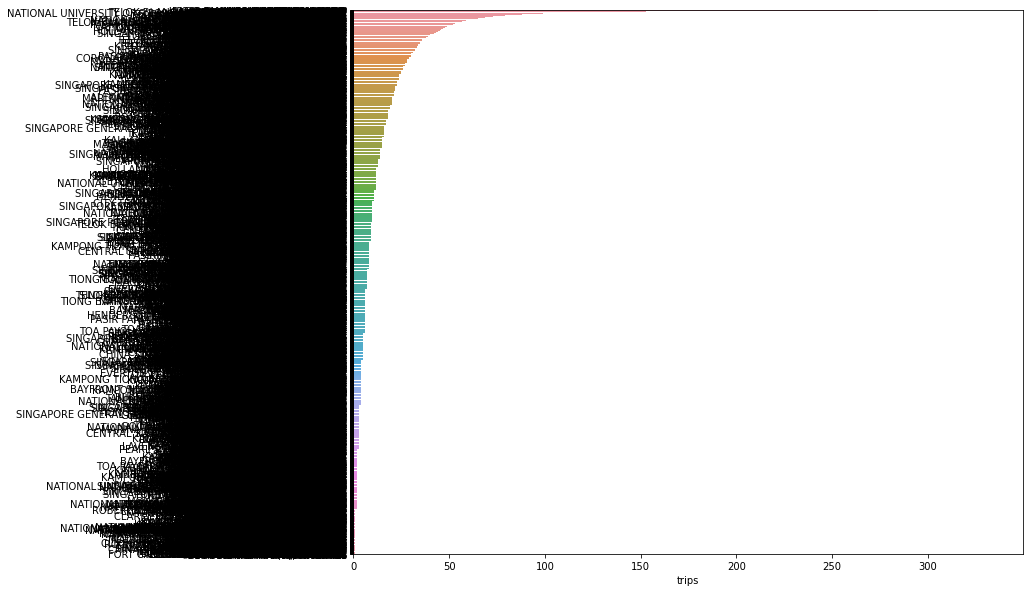

In [36]:
names = links.start + '/' + links.end
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ; 

In [37]:
pd.pivot_table(links, index='start', values='trips', columns='end')

end              ALEXANDRA HILL  ALEXANDRA NORTH  ALJUNIED  ANAK BUKIT  ANSON  \
start                                                                           
ALEXANDRA HILL             66.0             12.0      62.0        22.0    9.0   
ALEXANDRA NORTH             2.0              6.0      19.0         NaN    NaN   
ALJUNIED                   59.0              NaN     333.0        20.0   12.0   
ANAK BUKIT                  6.0             18.0      10.0       323.0    4.0   
ANSON                       4.0              NaN      31.0         NaN    3.0   
...                         ...              ...       ...         ...    ...   
TYERSALL                   31.0             21.0      24.0        26.0    8.0   
ULU PANDAN                  NaN              NaN       NaN       106.0    NaN   
UPPER THOMSON              36.0             11.0       NaN         6.0    NaN   
VICTORIA                    9.0              NaN      44.0         4.0    NaN   
WOODLEIGH                  11.0              NaN       NaN         NaN    NaN   

end              BALESTIER  BAYFRONT SUBZONE  BENCOOLEN  BENDEMEER  BIDADARI  \
start                                                                          
ALEXANDRA HILL        50.0               NaN        NaN       24.0       NaN   
ALEXANDRA NORTH       23.0               NaN        NaN        NaN       NaN   
ALJUNIED              93.0               NaN        9.0       59.0      18.0   
ANAK BUKIT             NaN               NaN        NaN       33.0       NaN   
ANSON                 12.0               2.0        NaN        4.0       NaN   
...                    ...               ...        ...        ...       ...   
TYERSALL               NaN               8.0        NaN        NaN       NaN   
ULU PANDAN             NaN               NaN        NaN        NaN       NaN   
UPPER THOMSON         94.0               NaN        NaN       24.0       NaN   
VICTORIA               6.0               NaN        4.0       13.0       NaN   
WOODLEIGH             12.0               NaN        NaN        NaN       NaN   

end              ...  TELOK BLANGAH WAY  TIONG BAHRU  TIONG BAHRU STATION  \
start            ...                                                        
ALEXANDRA HILL   ...               12.0         13.0                 26.0   
ALEXANDRA NORTH  ...                NaN          4.0                  4.0   
ALJUNIED         ...                NaN         12.0                 13.0   
ANAK BUKIT       ...                NaN          NaN                  NaN   
ANSON            ...                NaN          NaN                  NaN   
...              ...                ...          ...                  ...   
TYERSALL         ...                NaN          8.0                 16.0   
ULU PANDAN       ...                NaN          NaN                  NaN   
UPPER THOMSON    ...                NaN          NaN                  NaN   
VICTORIA         ...                3.0          NaN                  1.0   
WOODLEIGH        ...                NaN          NaN                  NaN   

end              TOA PAYOH CENTRAL  TOA PAYOH WEST  TYERSALL  ULU PANDAN  \
start                                                                      
ALEXANDRA HILL                16.0             NaN       8.0         2.0   
ALEXANDRA NORTH                6.0             NaN       NaN         NaN   
ALJUNIED                      35.0             NaN      15.0        24.0   
ANAK BUKIT                    21.0             NaN      75.0         1.0   
ANSON                          2.0             NaN       NaN         NaN   
...                            ...             ...       ...         ...   
TYERSALL                      12.0             NaN      49.0        52.0   
ULU PANDAN                     NaN             NaN       NaN        78.0   
UPPER THOMSON                 98.0            40.0      55.0        86.0   
VICTORIA                       7.0             3.0       7.0       

In [41]:
chord=hv.Chord(links[:60])
chord.opts(node_color='index', edge_color='start',\
          label_index='index', cmap='Category10', edge_cmap='Category10')

:Chord   [start,end]   (trips)

In [50]:
# TESTCASE 2 
areas = ['BUKIT BATOK', 'CLEMENTI', 'JURONG EAST']
trips = final_df[['SUBZONE_N_x', 'SUBZONE_N_y']]\
    .loc[((final_df['PLN_AREA_N_x']=='BUKIT BATOK') & (final_df['PLN_AREA_N_y']=='BUKIT BATOK'))]\
    .value_counts()

trips.head()

SUBZONE_N_x          SUBZONE_N_y        
HILLVIEW             HILLVIEW               235
BUKIT BATOK CENTRAL  BUKIT BATOK CENTRAL    163
HILLVIEW             BUKIT BATOK CENTRAL    134
BUKIT BATOK CENTRAL  HILLVIEW               131
BUKIT BATOK SOUTH    BUKIT BATOK CENTRAL    125
dtype: int64

In [51]:
links = pd.DataFrame.from_records(list(trips.index),\
                                 columns = ['start', 'end'])
links['trips'] = trips.values

links.head()

start                  end  trips
0             HILLVIEW             HILLVIEW    235
1  BUKIT BATOK CENTRAL  BUKIT BATOK CENTRAL    163
2             HILLVIEW  BUKIT BATOK CENTRAL    134
3  BUKIT BATOK CENTRAL             HILLVIEW    131
4    BUKIT BATOK SOUTH  BUKIT BATOK CENTRAL    125

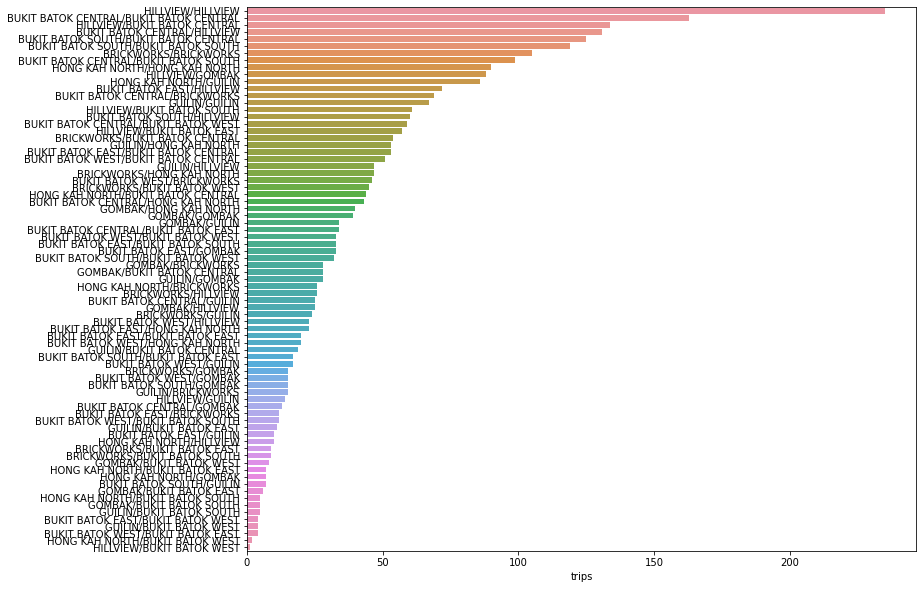

In [52]:
names = links.start + '/' + links.end
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ;

In [53]:
pd.pivot_table(links, index='start', values='trips', columns='end')

end                  BRICKWORKS  BUKIT BATOK CENTRAL  BUKIT BATOK EAST  \
start                                                                    
BRICKWORKS                105.0                 54.0               9.0   
BUKIT BATOK CENTRAL        69.0                163.0              34.0   
BUKIT BATOK EAST           12.0                 53.0              20.0   
BUKIT BATOK SOUTH           NaN                125.0              17.0   
BUKIT BATOK WEST           46.0                 51.0               4.0   
GOMBAK                     28.0                 28.0               6.0   
GUILIN                     15.0                 19.0              11.0   
HILLVIEW                    NaN                134.0              57.0   
HONG KAH NORTH             26.0                 44.0               7.0   

end                  BUKIT BATOK SOUTH  BUKIT BATOK WEST  GOMBAK  GUILIN  \
start                                                                      
BRICKWORKS                         9.0              45.0    15.0    24.0   
BUKIT BATOK CENTRAL               99.0              59.0    13.0    25.0   
BUKIT BATOK EAST                  33.0               4.0    33.0    10.0   
BUKIT BATOK SOUTH                119.0              32.0    15.0     7.0   
BUKIT BATOK WEST                  12.0              33.0    15.0    17.0   
GOMBAK                             5.0               8.0    39.0    34.0   
GUILIN                             5.0               4.0    28.0    67.0   
HILLVIEW                          61.0               1.0    88.0    14.0   
HONG KAH NORTH                     5.0               2.0     7.0    86.0   

end                  HILLVIEW  HONG KAH NORTH  
start                                          
BRICKWORKS               26.0            47.0  
BUKIT BATOK CENTRAL     131.0            43.0  
BUKIT BATOK EAST         72.0            23.0  
BUKIT BATOK SOUTH        60.0             NaN  
BUKIT BATOK WEST         23.0            20.0  
GOMBAK                   25.0            40.0  
GUILIN                   47.0            53.0  
HILLVIEW                235.0             NaN  
HONG KAH NORTH           10.0            90.0

In [54]:
chord=hv.Chord(links[:60])
chord.opts(node_color='index', edge_color='start',\
          label_index='index', cmap='Category10', edge_cmap='Category10')

:Chord   [start,end]   (trips)

In [55]:
# TESTCASE 3
trips = final_df[['SUBZONE_N_x', 'SUBZONE_N_y']]\
    .loc[((final_df['PLN_AREA_N_x']=='CLEMENTI') & (final_df['PLN_AREA_N_y']=='CLEMENTI'))]\
    .value_counts()

trips.head()

SUBZONE_N_x       SUBZONE_N_y     
TOH TUCK          TOH TUCK            144
CLEMENTI WEST     CLEMENTI WEST        78
CLEMENTI CENTRAL  CLEMENTI CENTRAL     74
TOH TUCK          CLEMENTI NORTH       71
CLEMENTI NORTH    CLEMENTI NORTH       71
dtype: int64

In [56]:
links = pd.DataFrame.from_records(list(trips.index),\
                                 columns = ['start', 'end'])
links['trips'] = trips.values

links.head()

start               end  trips
0          TOH TUCK          TOH TUCK    144
1     CLEMENTI WEST     CLEMENTI WEST     78
2  CLEMENTI CENTRAL  CLEMENTI CENTRAL     74
3          TOH TUCK    CLEMENTI NORTH     71
4    CLEMENTI NORTH    CLEMENTI NORTH     71

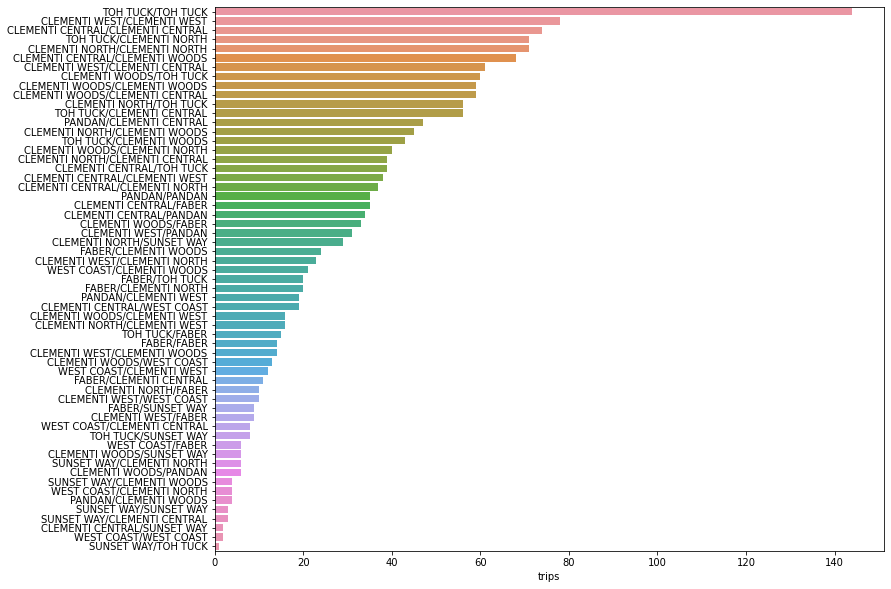

In [57]:
names = links.start + '/' + links.end
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ;

In [58]:
chord=hv.Chord(links[:60])
chord.opts(node_color='index', edge_color='start',\
          label_index='index', cmap='Category10', edge_cmap='Category10')

:Chord   [start,end]   (trips)

Creating the graph object with a general function:
`graph_obj` takes in three arguments - granularity, specific_subzone and min_num_of_trips - where granularity refers to the level at which you wish to look at the data - subzone, planning area or region. 

In [ ]:
def graph_obj(desired_area, specific_subzone, min_num_of_trips):
    # desired_subzones = desired_area
    # dest_subzones

    # trips = final_df['SUBZONE_N_x'].isin(desired_subzones)\
    #         .loc[(())]  